In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer, roc_auc_score
from sklearn.utils import shuffle
import bisect

def line(x_coords, y_coords):
    """
    Given a pair of coordinates (x1,y2), (x2,y2), define the line equation. Note that this is the entire line vs. t
    the line segment.

    Parameters
    ----------
    x_coords: Numpy array of 2 points corresponding to x1,x2
    x_coords: Numpy array of 2 points corresponding to y1,y2

    Returns
    -------
    (Gradient, intercept) tuple pair
    """    
    if (x_coords.shape[0] < 2) or (y_coords.shape[0] < 2):
        raise ValueError('At least 2 points are needed to compute'
                         ' area under curve, but x.shape = %s' % p1.shape)
    if ((x_coords[0]-x_coords[1]) == 0):
        raise ValueError("gradient is infinity")
    gradient = (y_coords[0]-y_coords[1])/(x_coords[0]-x_coords[1])
    intercept = y_coords[0] - gradient*1.0*x_coords[0]
    return (gradient, intercept)

def x_val_line_intercept(gradient, intercept, x_val):
    """
    Given a x=X_val vertical line, what is the intersection point of that line with the 
    line defined by the gradient and intercept. Note: This can be further improved by using line
    segments.

    Parameters
    ----------
    gradient
    intercept

    Returns
    -------
    (x_val, y) corresponding to the intercepted point. Note that this will always return a result.
    There is no check for whether the x_val is within the bounds of the line segment.
    """    
    y = gradient*x_val + intercept
    return (x_val, y)

def get_fpr_tpr_for_thresh(fpr, tpr, thresh):
    """
    Derive the partial ROC curve to the point based on the fpr threshold.

    Parameters
    ----------
    fpr: Numpy array of the sorted FPR points that represent the entirety of the ROC.
    tpr: Numpy array of the sorted TPR points that represent the entirety of the ROC.
    thresh: The threshold based on the FPR to extract the partial ROC based to that value of the threshold.

    Returns
    -------
    thresh_fpr: The FPR points that represent the partial ROC to the point of the fpr threshold.
    thresh_tpr: The TPR points that represent the partial ROC to the point of the fpr threshold
    """    
    p = bisect.bisect_left(fpr, thresh)
    thresh_fpr = fpr[:p+1].copy()
    thresh_tpr = tpr[:p+1].copy()
    g, i = line(fpr[p-1:p+1], tpr[p-1:p+1])
    new_point = x_val_line_intercept(g, i, thresh)
    thresh_fpr[p] = new_point[0]
    thresh_tpr[p] = new_point[1]
    return thresh_fpr, thresh_tpr


def partial_auc_scorer(fpr, tpr, decile=1):
    """
    Derive the AUC based of the partial ROC curve from FPR=0 to FPR=decile threshold.

    Parameters
    ----------
    y_actual: numpy array of the actual labels.
    y_pred: Numpy array of The predicted probability scores.
    decile: The threshold based on the FPR to extract the partial ROC based to that value of the threshold.

    Returns
    -------
    AUC of the partial ROC. A value that ranges from 0 to 1.
    """        
    fpr_thresh, tpr_thresh = get_fpr_tpr_for_thresh(fpr, tpr, decile)
    return auc(fpr_thresh, tpr_thresh)

In [2]:
# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
filename = 'C:\\AIA-2018\\examples\\feature-tables\\train-data_1527086478.csv'
data = pd.read_csv(filename)
data = data.drop(['Unnamed: 0'],axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data_per_imgfile = list(data.groupby('img_name'))
np.random.shuffle(data_per_imgfile)

# Splits in two datasets, for training and testing, with all regions associated to one image in the same set
data1 = []
data2 = []
i = 0
for name, group in data_per_imgfile:
    if i % 2 == 0:
        train = data[data['img_name']==name]
        data1.append(train)
    else:
        test = data[data['img_name']==name]
        data2.append(test)
    i += 1
dataset_df1 = pd.concat(data1)
dataset_df2 = pd.concat(data2)

In [3]:
# Converts from dataframe to numpy array
# Change here (or copy the code) if you want to select only some of the features to the array
# (only texture features, only geomatrical features...)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data = np.concatenate((dataset01_data, dataset02_data),axis=0)
all_labels = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)
#dataset02_data = preprocessing.robust_scale(dataset02_data)

In [4]:
# Trains and tests the classifier with both datasets (first considers the first dataset as the training set and the second as
# test, then inverts it)

# Classifier parameters
#svclassifier = SVC(C=0.10, class_weight={1:100}, kernel='linear', probability=True)
#svclassifier = SVC(C=0.1, class_weight={1: 5}, gamma=0.001, kernel='sigmoid', probability=True)
svclassifier = SVC(C=0.5, class_weight={1: 7}, gamma=0.003, kernel='rbf', probability=True)

# Trains classifier in DataSet01 and tests in DataSet02
svclassifier.fit(dataset01_data, dataset01_labels)
prob1 = svclassifier.predict_proba(dataset02_data)
prob1 = np.column_stack((prob1,dataset02_labels))

# Trains classifier in DataSet02 and tests in DataSet01
svclassifier.fit(dataset02_data, dataset02_labels)
prob2 = svclassifier.predict_proba(dataset01_data)
prob2 = np.column_stack((prob2,dataset01_labels))

# Calculate the probabilities taking both tests into account
full_prob = np.concatenate((prob1,prob2),axis=0)

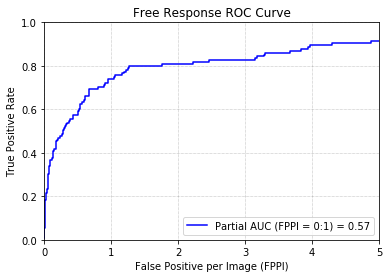

Partial area under the curve for FPPI between 0 and 1:  56.542948038176036 %


In [5]:
# FROC Curve section for the cross-validation test
false_positive_rate, true_positive_rate, thresholds = roc_curve(full_prob[:,-1], full_prob[:,1], pos_label=1, drop_intermediate=True)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Counts to adjust the TPR and to create the False Positive per Image
unique, counts = np.unique(full_prob[:,-1], return_counts=True)
num_img = 410
num_pos_img = 115
regions = full_prob[:,-1].shape[0]
pos_reg = counts[1]
neg_reg = counts[0]
neg_reg_per_img = neg_reg / num_img
false_positive_rate = false_positive_rate * neg_reg_per_img
true_positive_rate = true_positive_rate * pos_reg / num_pos_img

# Calculates Partial AUC
partial_AUC = partial_auc_scorer(false_positive_rate, true_positive_rate, 1)

# Plots the FROC Curve
plt.title('Free Response ROC Curve')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='Partial AUC (FPPI = 0:1) = %0.2f'% partial_AUC)
plt.legend(loc='lower right')
plt.xlim([-0,5])
plt.ylim([-0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive per Image (FPPI)')
plt.grid(color='k', linestyle='dotted', linewidth=0.5, alpha=0.5)
plt.show()

print("Partial area under the curve for FPPI between 0 and 1: ", partial_AUC * 100, "%")

In [ ]:
# Scores for Grid Searches
calculate_MCC = make_scorer(matthews_corrcoef)
calculate_AUC = make_scorer(roc_auc_score)

# Grid Search 1
parameters = [
  {'C': [0.01, 0.1, 0.1, 1, 5], 'kernel': ['linear'], 'class_weight':['balanced',{1:5},{1:7}]}
]

gridSVM = svm.SVC()
grid_search1 = GridSearchCV(gridSVM, parameters, scoring=calculate_AUC, cv=2)
grid_search1.fit(all_data, all_labels)

In [ ]:
print(grid_search1.best_score_, grid_search1.best_params_)

In [ ]:
# Grid Search 2
parameters = [
  {'C': [0.001, 0.01, 0.1, 0.5, 5, 9], 'gamma': [1e-4, 0.003, 0.007, 0.01, 0.05, 0.1, 0.5], 'kernel': ['rbf'], 'class_weight':['balanced',{1:7},{1:9},{1:10},{1:11},{1:12}]}
]

gridSVM = svm.SVC()
grid_search2 = GridSearchCV(gridSVM, parameters, scoring=calculate_AUC)
grid_search1.fit(all_data, all_labels)

In [ ]:
print(grid_search2.best_score_, grid_search2.best_params_)

In [ ]:
# Grid Search 3
parameters = [
  {'C': [0.1, 0.3, 0.5, 0.7, 0.01, 10, 100], 'gamma': [1e-4, 1e-3, 0.0005, 0.001, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5], 'kernel': ['sigmoid'], 'class_weight':['balanced',{1:5},{1:3},{1:7},{1:1},{1:100}]}
]

gridSVM = svm.SVC()
grid_search3 = GridSearchCV(gridSVM, parameters, scoring=calculate_AUC)
grid_search1.fit(all_data, all_labels)

In [ ]:
print(grid_search3.best_score_, grid_search3.best_params_)

In [ ]:
# Grid Search 4
parameters = [
  {'C': [0.1, 1, 10], 'gamma': [1e-3, 0.01, 0.1], 'kernel': ['poly'], 'class_weight':[{1:5},{1:10}],'degree':[1,5], 'coef0':[1.0, 2.0]}
]

gridSVM = svm.SVC()
grid_search4 = GridSearchCV(gridSVM, parameters, scoring=calculate_AUC)
grid_search1.fit(all_data, all_labels)